# Ejercicio 1: 

### Usa la clase PairWiseAligner de Biopython para alinear secuencias de ADN y obtener la puntuación y el alineamiento óptimo en estos dos escenarios.

In [5]:
from Bio.Align import PairwiseAligner
from Bio.Seq import Seq
from Bio import Entrez, SeqIO
import random
import warnings
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
import os

### a) Generar las secuencias aleatoriamente (de forma automática no manual). Las dos secuencias pueden ser de diferente longitud.

#### 1. Generación de secuencias aleatorias

In [115]:
def generate_random_dna_sequence(length):
    return ''.join(random.choice('ACGT') for _ in range(length))

In [116]:
seq1 = Seq(generate_random_dna_sequence(random.randint(10, 20)))
seq2 = Seq(generate_random_dna_sequence(random.randint(15, 25)))

print(seq1)
print(seq2)

AGTAGGCCTGCAC
GCATGGTATGGCGCTCT


#### 2. Alineamiento de secuencias mediante búsqueda en rejilla

In [117]:
param_grid = {
    "mode": ["global", "local"],
    "match_score": [1, 2, 3],
    "mismatch_score": [-1, -2, -3],
    "open_gap_score": [-2, -3, -4],
    "extend_gap_score": [-0.5, -1, -1.5],
}

grid_combinations = list(product(
    param_grid["mode"],
    param_grid["match_score"],
    param_grid["mismatch_score"],
    param_grid["open_gap_score"],
    param_grid["extend_gap_score"],
))

In [118]:
def align_with_parameters(seq1, seq2, **kwargs):
    aligner = PairwiseAligner()
    for key, value in kwargs.items():
        setattr(aligner, key, value)
    alignment = aligner.align(seq1, seq2)
    return alignment.score, alignment

In [119]:
results = []
for params in grid_combinations:
    param_dict = {
        "mode": params[0],
        "match_score": params[1],
        "mismatch_score": params[2],
        "open_gap_score": params[3],
        "extend_gap_score": params[4],
    }
    score, alignment = align_with_parameters(seq1, seq2, **param_dict)

    results.append({
        "params": param_dict,
        "score": score,
        "alignment": alignment,
    })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="score", ascending=False)

#### 3. Análisis de resultados

In [120]:
results_df["mode"] = results_df["params"].apply(lambda x: x["mode"])
results_df["match_score"] = results_df["params"].apply(lambda x: x["match_score"])
results_df["mismatch_score"] = results_df["params"].apply(lambda x: x["mismatch_score"])
results_df["open_gap_score"] = results_df["params"].apply(lambda x: x["open_gap_score"])
results_df["extend_gap_score"] = results_df["params"].apply(lambda x: x["extend_gap_score"])

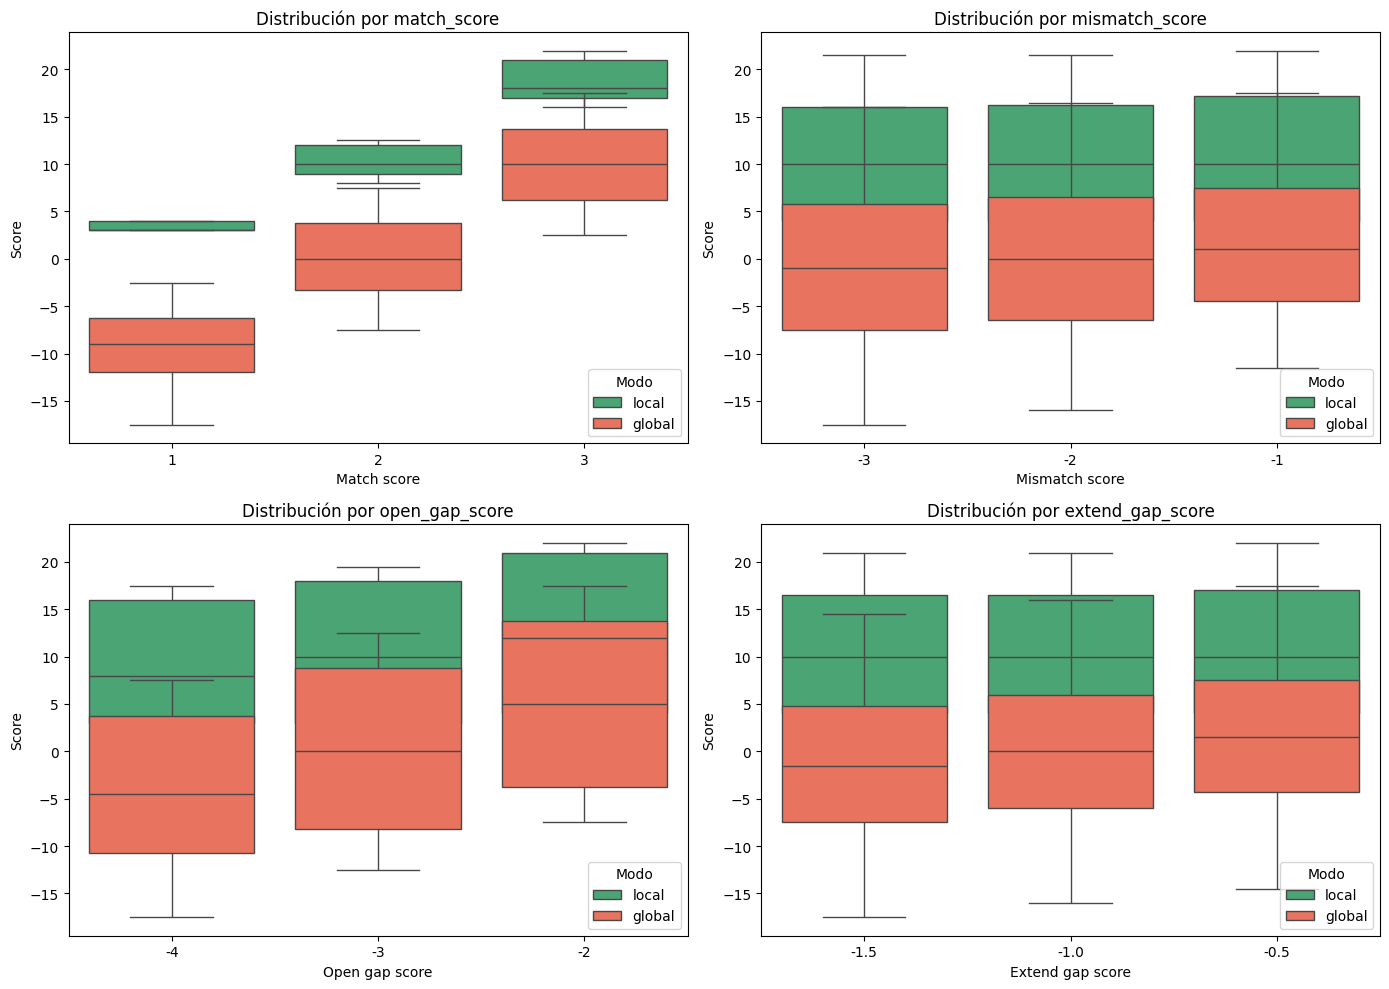

In [121]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
param_keys = ["match_score", "mismatch_score", "open_gap_score", "extend_gap_score"]
titles = [
    "Distribución por match_score",
    "Distribución por mismatch_score",
    "Distribución por open_gap_score",
    "Distribución por extend_gap_score"    
]
palette = {
    "global": "tomato",
    "local": "mediumseagreen",
}

for i, key in enumerate(param_keys):
    ax = axes[i // 2, i % 2]
    sns.boxplot(
        data=results_df,
        x=key,
        y="score",
        hue="mode",
        palette=palette,
        dodge=False,
        ax=ax
    )
    ax.set_title(titles[i])
    ax.set_xlabel(key.capitalize().replace("_", " "))
    ax.set_ylabel("Score")
    ax.legend(loc='lower right', title="Modo")

plt.tight_layout()
plt.show()

Por un lado, el modo local ofrece un mejor desempeño en términos de puntajes, especialmente con parámetros más permisivos. Esto se debe a que el alineamiento local se enfoca en las regiones más similares de las secuencias, ignorando áreas menos relevantes. Sin embargo, el modo global es más sensible a penalizaciones, debido a su necesidad de alinear toda la longitud de las secuencias, lo que amplifica el impacto de desajustes y brechas.

Por otro lado, Los parámetros como *match_score* tienen un impacto positivo directo: un mayor valor recompensa mejor las coincidencias entre secuencias mientras que las penalizaciones (*mismatch_score*, *open_gap_score*, *extend_gap_score*) tienen un impacto negativo, reduciendo los puntajes a medida que se vuelven más severas. De todos los parámetros, el *match_score* y el *mismatch_score* parecen tener el mayor efecto en el *score* final.

In [122]:
warnings.filterwarnings("ignore")
local_results = results_df[results_df["mode"] == "local"]

bins, bin_edges = pd.cut(
    local_results["score"],
    bins=3,
    retbins=True 
)

range_labels = [f"[{bin_edges[i]:.1f} - {bin_edges[i + 1]:.1f}]" for i in range(len(bin_edges) - 1)]
local_results["score_group"] = pd.cut(
    local_results["score"],
    bins=bin_edges,
    labels=range_labels
)

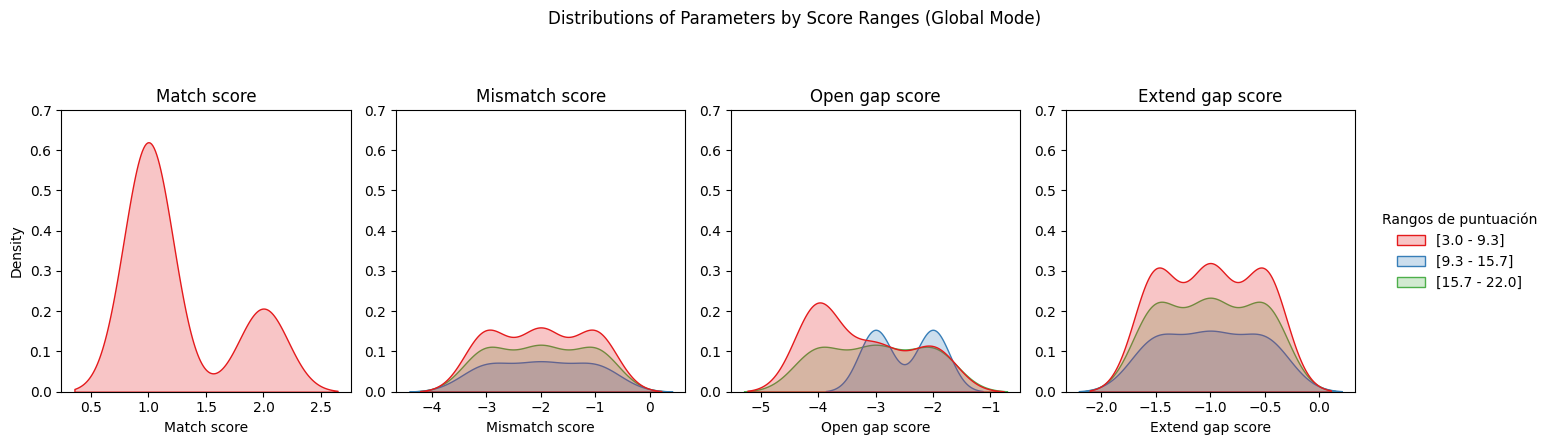

In [129]:
fig, axes = plt.subplots(1, len(local_results[["match_score", "mismatch_score", "open_gap_score", "extend_gap_score"]].columns), figsize=(16, 4))
handles, labels = None, None

for i, var in enumerate(["match_score", "mismatch_score", "open_gap_score", "extend_gap_score"]):
    kde = sns.kdeplot(
        data=local_results,
        x=var,
        hue="score_group",
        fill=True,
        palette="Set1",
        ax=axes[i]
    )
    axes[i].set_title(var.capitalize().replace("_", " "))
    axes[i].set_xlabel(var.capitalize().replace("_", " "))
    axes[i].set_ylim(0, 0.7)

    if i == 0:
        axes[i].set_ylabel("Density")
    else:
        axes[i].set_ylabel("")

    if handles is None and kde.legend_:
        handles, labels = kde.get_legend().get_patches(), kde.get_legend().get_texts()

    if i < len(axes) - 1 and kde.legend_:
        kde.legend_.remove()

if handles and labels:
    axes[-1].legend(
        handles=handles,
        labels=[label.get_text() for label in labels],
        title="Rangos de puntuación",
        bbox_to_anchor=(1.05, 0.5), 
        loc="center left", 
        frameon=False
    )

plt.tight_layout()
plt.suptitle("Distributions of Parameters by Score Ranges (Global Mode)", y=1.1)
plt.subplots_adjust(top=0.85, right=0.85)
plt.show()

Las gráficas muestran la relación entre los diferentes parámetros configurados para los alineamientos **locales** y cómo estos influyen en las puntuaciones obtenidas.

1. **Match Score:** refleja la recompensa asignada a las coincidencias exactas entre las secuencias. Las gráficas indican que un *match_score* alto resulta en una mayor densidad de puntuaciones en rangos superiores, especialmente para secuencias con regiones altamente conservadas. Esto demuestra que incrementar este parámetro favorece alineamientos más sólidos y con mejores puntuaciones para regiones similares.

2. **Mismatch Score:** penaliza los desajustes entre las secuencias. La distribución de densidades muestra que penalizaciones menos severas (*mismatch_score* cercano a 0) están asociadas con puntuaciones más altas. Esto ocurre porque los desajustes tienen un impacto reducido en la puntuación total, permitiendo mayor permisividad en los alineamientos.

3. **Open Gap Score:** determina la penalización al abrir una brecha en el alineamiento. Las densidades en las gráficas reflejan que penalizaciones menos estrictas generan puntuaciones más altas, ya que esto permite introducir huecos cuando es necesario para maximizar el alineamiento de regiones conservadas. Esto es útil para secuencias con interrupciones o inserciones/deleciones.

4. **Extend Gap Score:** Similar al *open_gap_score*, este parámetro controla la penalización al extender una brecha existente. Penalizaciones más bajas favorecen puntuaciones más altas, especialmente cuando las secuencias tienen largos tramos con inserciones o deleciones, pero conservan regiones alineables.

En conjunto, las gráficas evidencian cómo ajustes estratégicos en estos parámetros pueden optimizar los alineamientos locales. Parámetros menos estrictos en penalizaciones (desajustes y brechas) y valores altos para coincidencias exactas generan puntuaciones superiores, especialmente en secuencias con regiones parcialmente conservadas. Esto permite identificar configuraciones ideales para analizar similitudes y variaciones en secuencias biológicas.

In [130]:
warnings.filterwarnings("ignore")
global_results = results_df[results_df["mode"] == "global"]

bins, bin_edges = pd.cut(
    global_results["score"],
    bins=6,
    retbins=True 
)

range_labels = [f"[{bin_edges[i]:.1f} - {bin_edges[i + 1]:.1f}]" for i in range(len(bin_edges) - 1)]
global_results["score_group"] = pd.cut(
    global_results["score"],
    bins=bin_edges,
    labels=range_labels
)

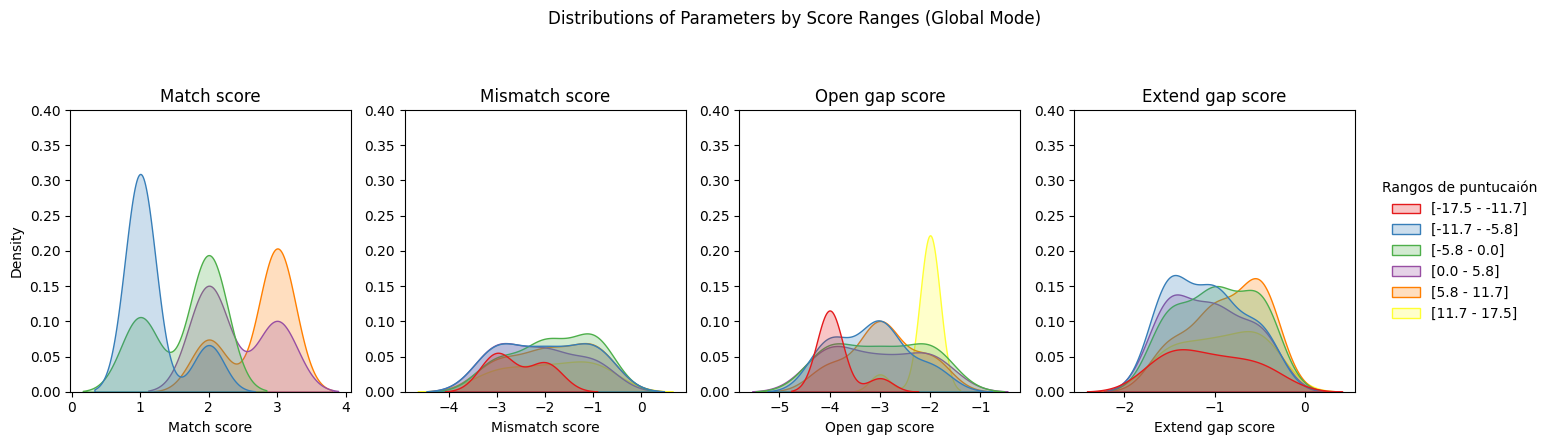

In [131]:
fig, axes = plt.subplots(1, len(global_results[["match_score", "mismatch_score", "open_gap_score", "extend_gap_score"]].columns), figsize=(16, 4))
handles, labels = None, None

for i, var in enumerate(["match_score", "mismatch_score", "open_gap_score", "extend_gap_score"]):
    kde = sns.kdeplot(
        data=global_results,
        x=var,
        hue="score_group",
        fill=True,
        palette="Set1",
        ax=axes[i]
    )
    axes[i].set_title(var.capitalize().replace("_", " "))
    axes[i].set_xlabel(var.capitalize().replace("_", " "))
    axes[i].set_ylim(0, 0.4)

    if i == 0:
        axes[i].set_ylabel("Density")
    else:
        axes[i].set_ylabel("")

    if handles is None and kde.legend_:
        handles, labels = kde.get_legend().get_patches(), kde.get_legend().get_texts()

    if i < len(axes) - 1 and kde.legend_:
        kde.legend_.remove()

if handles and labels:
    axes[-1].legend(
        handles=handles,
        labels=[label.get_text() for label in labels],
        title="Rangos de puntucaión",
        bbox_to_anchor=(1.05, 0.5), 
        loc="center left", 
        frameon=False
    )

plt.tight_layout()
plt.suptitle("Distributions of Parameters by Score Ranges (Global Mode)", y=1.1)
plt.subplots_adjust(top=0.85, right=0.85)
plt.show()

Las gráficas representan cómo los diferentes parámetros configurados afectan las puntuaciones de alineamientos **globales**, donde se intenta alinear las secuencias completas de manera estricta.

1. **Match Score:** Las gráficas reflejan que, a medida que aumenta el `match_score`, se observan densidades más altas en los rangos superiores de puntuación. Esto es especialmente relevante para secuencias altamente similares, donde un valor elevado de `match_score` refuerza el peso de las coincidencias en el alineamiento global.

2. **Mismatch Score:** Penalizaciones por desajustes (`mismatch_score`) más severas (valores negativos mayores) disminuyen las puntuaciones finales, ya que cualquier discrepancia entre las secuencias impacta significativamente. Las gráficas muestran que puntuaciones más altas se logran con valores de penalización más cercanos a 0, permitiendo un alineamiento más tolerante a desajustes.

3. **Open Gap Score:** Este parámetro regula la penalización por introducir una brecha en el alineamiento. Penalizaciones menos estrictas permiten puntuaciones más altas, favoreciendo alineamientos más flexibles cuando las secuencias contienen inserciones o deleciones. Las densidades reflejan que puntuaciones superiores se logran al reducir esta penalización, aunque en alineamientos globales, el impacto de las brechas suele ser mayor que en los alineamientos locales.

4. **Extend Gap Score:** Similar al `open_gap_score`, este parámetro controla el costo de extender brechas ya abiertas. Las gráficas indican que puntuaciones más altas están asociadas a penalizaciones más bajas para extensiones de brechas, lo que permite manejar mejor las diferencias estructurales entre las secuencias.

En los alineamientos globales, los parámetros tienen un impacto pronunciado porque todas las discrepancias y brechas entre las secuencias afectan directamente la puntuación final. Configuraciones con un `match_score` alto y penalizaciones menos estrictas para desajustes y brechas permiten maximizar las puntuaciones, aunque esto podría reducir la precisión en secuencias menos conservadas. Estas gráficas subrayan la importancia de ajustar los parámetros cuidadosamente para optimizar la alineación de secuencias completas.

#### 4. Conclusiones Generales

Los resultados evidencian que el desempeño de los alineamientos está estrechamente ligado a la configuración de parámetros y al tipo de alineamiento seleccionado (local o global). En términos generales, los alineamientos **locales** tienden a ofrecer mejores puntajes debido a su enfoque en regiones altamente similares, mientras que los **globales** son más sensibles a penalizaciones ya que consideran la totalidad de las secuencias.

1. **Impacto de los Parámetros:**
   - **Match Score:** Este parámetro tiene un impacto positivo directo en ambos modos de alineamiento. Valores más altos de *match_score* aumentan significativamente las puntuaciones al recompensar las coincidencias exactas, especialmente en secuencias conservadas. Es el parámetro más determinante para mejorar los puntajes.
   - **Mismatch Score:** Penalizaciones menos estrictas (*mismatch_score* cercano a 0) permiten mayores puntuaciones, ya que reducen el impacto de desajustes. Este efecto es más evidente en alineamientos locales, donde se priorizan regiones similares, mientras que en los globales, los desajustes afectan más debido al alineamiento completo.
   - **Open Gap Score y Extend Gap Score:** Penalizaciones menos severas para abrir y extender brechas son beneficiosas para obtener mejores puntuaciones. En los alineamientos locales, esto permite una mayor flexibilidad en regiones con inserciones o deleciones, mientras que en los globales, el impacto de las brechas es más crítico.

2. **Diferencias entre Modos de Alineamiento:**
   - El **modo local** se destaca por su capacidad para enfocarse en las regiones más relevantes, ignorando partes menos similares de las secuencias. Esto permite manejar configuraciones más permisivas sin un impacto significativo en los puntajes finales, resultando ideal para secuencias con regiones parcialmente conservadas.
   - El **modo global**, en cambio, requiere un ajuste más cuidadoso de los parámetros debido a su sensibilidad a penalizaciones y desajustes. Si bien es más estricto, puede ser útil para obtener una visión general de similitudes a lo largo de toda la longitud de las secuencias.

**Conclusión Final**

Los parámetros deben ajustarse estratégicamente según el propósito del análisis. Para regiones altamente conservadas o análisis focalizados, el modo local con configuraciones permisivas es óptimo. Para comparaciones más amplias y detalladas, el modo global con un balance adecuado entre recompensas (*match_score*) y penalizaciones (*mismatch_score*, *gap scores*) ofrece una visión más completa. Este enfoque permite maximizar la utilidad de los alineamientos para analizar similitudes, diferencias estructurales y relaciones evolutivas entre secuencias.

### b)  Obtener las secuencias a partir de ficheros obtenidos de bases de datos  biológicas. Explicar cómo se obtuvieron.

In [8]:
def get_sequences_ncbi(db, search_term, format="fasta", max_results=5, folder="sequences"):

    with Entrez.esearch(db=db, term=search_term, retmax=max_results) as search:
        results = Entrez.read(search)
        ids = results["IdList"]
        print(f"IDs found: {ids}")

    get_sequences_by_id(ids, db, folder)

def get_sequences_by_id(ids, db="nucleotide", folder="sequences"):
    for id in ids:
        with Entrez.efetch(db=db, id=id, rettype="fasta", retmode="text") as fetch:
            content = fetch.read()
        filename = id.replace(".", "_") + ".fasta"
        file_route = os.path.join(folder, filename)

        with open(file_route, "w") as file:
            file.write(content)
            print(f"File {filename} created")

In [10]:
warnings.filterwarnings("ignore")
sequences = get_sequences_ncbi("nucleotide", "BRCA1 Homo sapiens", format="fasta", max_results=2)

IDs found: ['2288627445', '1519244207']
File 2288627445.fasta created
File 1519244207.fasta created


### Prueba a cambiar los parámetros del alineador como el esquema de puntuación, las penalizaciones de alineamiento y la modalidad de alineamiento (global o local). Compara los resultados obtenidos con diferentes configuraciones y explica las diferencias.